# 数据集定制化

由于pytorch中数据集也不是应有尽有的，所以，在某些情况下，需要我们自己定制数据集 

## 1. 引入包

In [2]:
import torch
from torch import nn


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. 获取data

这里使用food101，现在从github上获取

In [6]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"didn't find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 3. 数据是首要的

> If I had 8 hours to build a meachine learning model, i'd spend the first 6 hours preparing my dataset. - Abraham Lossfunction


In [7]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} direcotries and {len(filenames)} images in '{dirpath}'")
walk_through_dir(image_path)

# 定义train 和 test 路径
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

there are 2 direcotries and 0 images in 'data/pizza_steak_sushi'
there are 3 direcotries and 0 images in 'data/pizza_steak_sushi/test'
there are 0 direcotries and 19 images in 'data/pizza_steak_sushi/test/steak'
there are 0 direcotries and 31 images in 'data/pizza_steak_sushi/test/sushi'
there are 0 direcotries and 25 images in 'data/pizza_steak_sushi/test/pizza'
there are 3 direcotries and 0 images in 'data/pizza_steak_sushi/train'
there are 0 direcotries and 75 images in 'data/pizza_steak_sushi/train/steak'
there are 0 direcotries and 72 images in 'data/pizza_steak_sushi/train/sushi'
there are 0 direcotries and 78 images in 'data/pizza_steak_sushi/train/pizza'


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 可视化、可视化、可视化

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


(-0.5, 511.5, 511.5, -0.5)

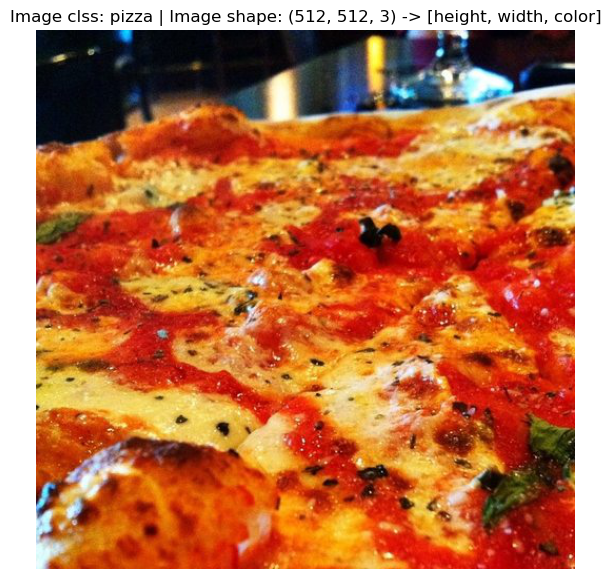

In [8]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image clss: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color]")
plt.axis(False)

## 3. Transforming data


加载图片数据转换为pytorch

1. 将其转换为tensor
2. 将其转换为Dataset以及DataLoader


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


由于此问题是图片的问题，所以使用torchvision.transforms来讲图片转为tensor

有以下几个步骤：

    1. 使用transforms.Resize()重置图片大小
    2. 使用transforms.RandomHorizontalFlip()在水平方向反转图片
    3. 使用transforms.ToTensor()将PIL图片转为pytorch tensor


In [10]:

# 实现将数据transform for tensor
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    # p = 0.5 是指flip的概率
    transforms.RandomHorizontalFlip(p = 0.5),
    # 将像素值（0，255）转为（0，1.0）
    transforms.ToTensor()
])

|问题|内建数据集|
|:----|:----|
|vision|torchvision.datasets|
|audio|torchaudio.datasets|
|text|torchtext.datasets|
|recommendation system|torchrec.datasets|


image_path_list properties: shapes 300
transformed_image 的类型<class 'torch.Tensor'>
transformed_image 的类型<class 'torch.Tensor'>
transformed_image 的类型<class 'torch.Tensor'>


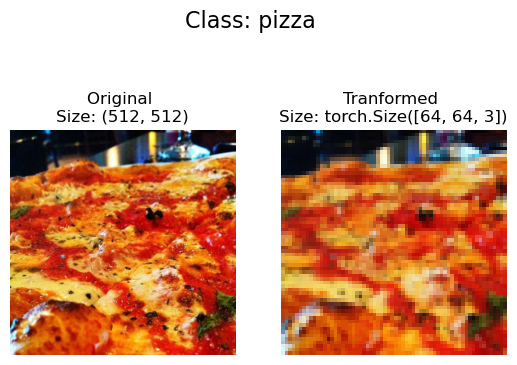

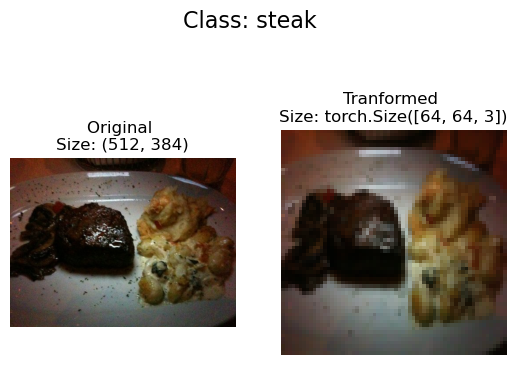

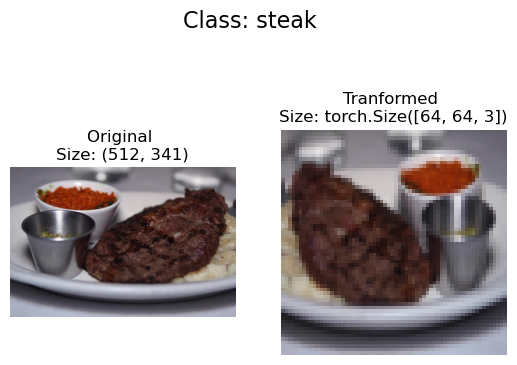

In [14]:
# 定义一个可以画出n轮图片的函数，使用transform函数将图片数据转换为tensor
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            # 这里使用我们定义好的transform函数，将图片PIL数据转为tensor数据
            # 并且使用permute函数将tensor的默认 chw 格式转为matplotlib的 hwc 格式
            transformed_image = transform(f).permute(1, 2, 0)
            # print(f"transformed_image 的类型{type(transformed_image)}")
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Tranformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

print(f"image_path_list properties: shapes {len(image_path_list)}")
plot_transformed_images(image_path_list, transform=data_transform, n=3)

## 使用ImageFolder加载图片数据


上面的data_transform函数是为了将图片数据转为Tensor，然后使用matplotlib将图片画出来

这个函数可以直接使用**ImageFolder**来将某个路径下的所有图片转为两列，第一列是图片的tensor（chw）数据，第二列是标签数据

如果我们要针对特殊问题，或者是datasets中没有对应Dataset的构建器，就需要自己定制**Custom**

In [39]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = train_dir,
                                 transform = data_transform)

train_data, train_data.classes, train_data.class_to_idx

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 ['pizza', 'steak', 'sushi'],
 {'pizza': 0, 'steak': 1, 'sushi': 2})

## Custom Dataset

In [40]:
import os
import pathlib
import torch

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

#### 获取类名，创建一个helper函数

In [41]:
target_directory = train_dir
print(f"目录: {target_directory}")
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"类名: {class_names_found}")

目录: data/pizza_steak_sushi/train
类名: ['pizza', 'steak', 'sushi']


#### 创建custom dataset去复制ImageFolder

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir:str, transform=None) :
        super.__init__()